In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import least_squares

In [2]:
def average_rows(x,nblock=100):
    nr=x.shape[0]//nblock
    nc=x.shape[1]
    y=np.zeros((nr,nc),dtype=x.dtype)
    for i in range(nr):
        y[i,:]=np.mean(x[i*nblock:(i+1)*nblock],axis=0)
    return y

In [4]:
def get_coarse_xcorr(f1,f2,chans=None):
    """ Get coarse xcorr of each channel of two channelized timestreams.
    The xcorr is 0-padded, so length of output is twice the original length (shape[0]).
    
    Parameters
    ----------
    f1, f2 : ndarray of complex64
        First and second timestreams. Both n_spectrum x n_channel complex array.
    chans: tuple of int
        Channels (columns) of f1 and f2 that should be correlated.
    
    Returns
    -------
    ndarray of complex128
        xcorr of each channel's timestream. 2*n_spectrum x n_channel complex array.
    """
    Nsmall=f1.shape[0]
    print("Shape of passed channelized timestream =", f1.shape)
    if chans is None:
        chans = np.arange(f1.shape[1])
    xcorr=np.zeros((len(chans),2*Nsmall),dtype='complex128')
    win=np.hamming(2*Nsmall)
    wt = np.zeros(2*Nsmall)
    wt[:Nsmall] = 1
    n_avg = np.fft.irfft(np.fft.rfft(wt)*np.conj(np.fft.rfft(wt)))
    print(n_avg)
    for i,chan in enumerate(chans):
        print("processing chan", chan)
        xcorr[i, :] = np.fft.ifft(
                        np.fft.fft(np.hstack([f1[:, chan].flatten(), np.zeros(Nsmall, dtype="complex128")]))
                        * np.conj(
                            np.fft.fft(np.hstack([f2[:, chan].flatten(), np.zeros(Nsmall, dtype="complex128")]))
                        )
                    )
        xcorr[i, :]=xcorr[i, :]/n_avg
    print(xcorr.shape)
    return np.ma.masked_invalid(xcorr)

@nb.njit(parallel=True,cache=True)
def make_complex(cmpl,mag,phase):
    N=cmpl.shape[0]
    for i in nb.prange(0,N):
        cmpl[i] = mag[i]*np.exp(1J*phase[i])

def get_interp_xcorr(coarse_xcorr, freq, sample_no, coarse_sample_no, offset, osamp=1):
    print("coarse shape", coarse_xcorr.shape)
    t1=time.time()
    final_xcorr_cwave = np.empty((coarse_xcorr.shape[0]-1)*8192*osamp,dtype='complex128')
    print("Total upsampled timestream samples in this coarse chunk =",sample_no.shape)
    t2=time.time()
    print("generation",t2-t1)
    sample_no2 = sample_no + offset
    t1=time.time()
    uph=np.unwrap(np.angle(coarse_xcorr))
    t2=time.time()
    print("unwrap",t2-t1)
    newphase=2*np.pi*freq*np.arange(0,coarse_xcorr.shape[0])+uph
    t1=time.time()
    newphase=np.interp(sample_no,coarse_sample_no,newphase)
    t2=time.time()
    print("interp", t2-t1)
    t1=time.time()
    cs=CubicSpline(coarse_sample_no,np.abs(coarse_xcorr))
    t2=time.time()
    print("CS gen", t2-t1)
    t1=time.time()
    newmag=cs(sample_no2)
    t2=time.time()
    print("cs eval",t2-t1)
    t1=time.time()
    
    t1=time.time()
    make_complex(final_xcorr_cwave,newmag,newphase)
    t2=time.time()
    print("make complex",t2-t1)
    # newmag = np.interp(x,np.arange(0,len(y))*4096,np.abs(c1full))
    return final_xcorr_cwave

NameError: name 'nb' is not defined

In [113]:
def get_adev(x,tau,stidx=0,endidx=None):
    dt=4096/250e6
    delta=int(tau/dt)
#     print(delta)
    sl=slice(stidx,endidx,delta)
    samps=x[sl]
#     print(samps)
    adev=np.sqrt(np.mean((samps[2:]-2*samps[1:-1]+samps[:-2])**2)/(2*tau**2))
    return adev

In [3]:
with np.load("../spectra_1830_1840_4096.npz") as f:
    spec1=f['spectra1']
    spec2=f['spectra2']
    delays=f['delays']

In [5]:
spec1.shape, spec2.shape

((500000, 10), (500000, 10))

In [130]:
500000*16e-6

8.0

In [136]:
taus=10**np.linspace(-3,0,101)
# taus=np.linspace(0.1,2,1001)
adevs=np.zeros(len(taus))
for i,tau in enumerate(taus):
    adevs[i]=get_adev(delays,tau)

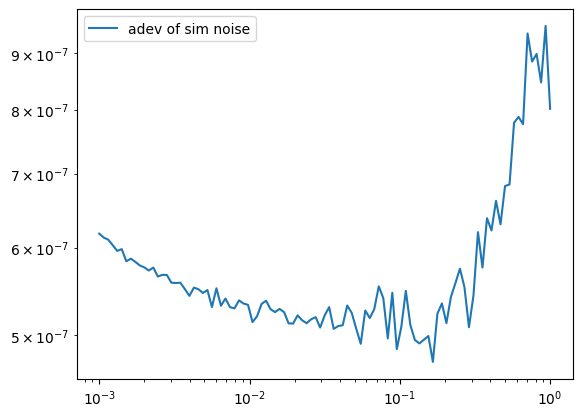

In [137]:
plt.loglog(taus,adevs*4e-9,label='adev of sim noise')
# params=np.polyfit(np.log10(taus), np.log10(adevs),2)
# plt.loglog(taus,10**np.polyval(params,np.log10(taus))*4e-9,label='quadratic fit')
plt.legend()
#4 to 5 OOM worse than actual LB ADEV. 

In [139]:
6e-7*1e-2/4e-9 #rough error in number of samples tau * adev(tau), for about 1000 spectra.

1.5

-0.002608899703658507 -120.36697773298944


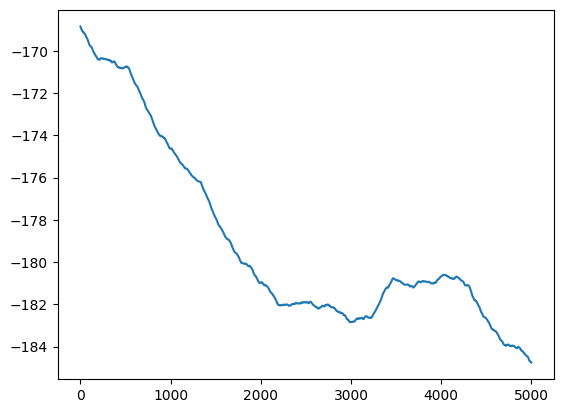

In [112]:
st=20000
en=25000
plt.plot(delays[st:en])
m,c=np.polyfit(np.arange(st,en),delays[st:en],1)
# m,c=np.polyfit(np.arange(0,en-st),delays[st:en]-delays[st],1)
print(m,c)
# plt.xlim(20000,50000)

In [97]:
#resolution with 500 fft size is
1/500 * (4096/1834)

0.004466739367502727

In [57]:
def newton(n,xc,alpha,chan,scale=1):
    c=2*np.pi*chan/4096
    N=len(xc)
    xc_phased = xc*np.exp(1j*c*n*alpha)
    S0conj=np.conj(np.mean(xc_phased))
    S1=np.mean(xc_phased*n*c)
    S2=np.mean(xc_phased*n**2*c**2)
    df=np.imag(S0conj*S1)
    ddf=np.real(S0conj*S2) - np.abs(S1)**2
    alpha2 = alpha - scale*df/ddf
    print(f"old alpha {alpha:5.3e}, df {df:5.3e}, ddf {ddf:5.3e}, step size {df/ddf:5.3e} new alpha {alpha2:5.3e} ")
    return alpha2

def solver(xc,alpha,chan,scale=1,atol=1e-10,rtol=1e-6):
    niter=10
    success=0
    N=len(xc)
    n = np.arange(N)
    for i in range(niter):
        alpha2=newton(n,xc,alpha,chan,scale=scale)
        if np.abs(alpha2) < atol:
            print("atol hit")
            success=1
            break
        if np.abs((alpha2-alpha)/alpha) < rtol:
            print("rtol hit")
            success=1
            break
        alpha=alpha2
    if not success:
        print("Max iterations, unsuccessful.")
    return alpha2

In [44]:
def objective_func(xc,alpha,chan):
    c=2*np.pi*chan/4096
    N=len(xc)
    n=np.arange(N)
    xc_phased = xc*np.exp(1j*c*n*alpha)
    return np.abs(np.mean(xc_phased))**2

In [110]:
y1=spec1[st:en,4]
y2=spec2[st:en,4]
xc_small = y1*np.conj(y2)
print(np.mean(xc_small))
xc_small = xc_small #* np.exp(-1j*np.angle(xc_small)[0]) #a constant phase offset is not what we care about
# print(np.angle(xc_small))
np.mean(xc_small)
#whether or not FFT will be useful depends on whether we can resolve the slow sine wave across the chunk being FFT'ed.

(-0.04664640198188927+0.028295910582347764j)


np.complex128(-0.04664640198188927+0.028295910582347764j)

10000
Max at 58.0
Expected delta= 0.012953544165757907


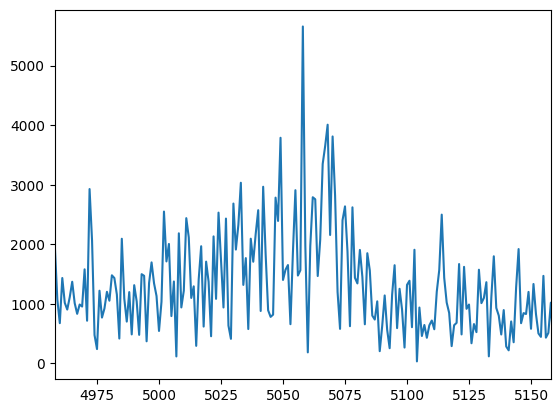

In [111]:
#take an fft to see which value to try.
xc_fft = np.fft.fftshift(np.abs(np.fft.fft(xc_small))) # should peak at -ve freq cause deltat is 2.5e-4, and fft is exp(-jomega t)
mm=np.argmax(xc_fft)
plt.plot(xc_fft)
plt.xlim(mm-100,mm+100)
M=len(xc_fft)
print(M)
print("Max at", mm-len(xc_fft)/2)
expected_delta = (mm-M/2)/M * (4096/1834)
print("Expected delta=", expected_delta)

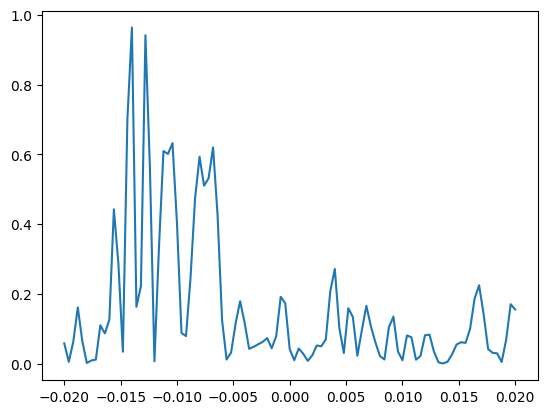

In [45]:
alphas=np.linspace(-2e-2,2e-2,101)
f_alpha = np.zeros(len(alphas))
for i in range(len(f_alpha)):
    f_alpha[i] = objective_func(xc_small,alphas[i],1834)
plt.plot(alphas,f_alpha)

In [100]:
alpha=expected_delta
solver(xc_small,alpha,1834,rtol=1e-4)

old alpha 1.340e-02, df 8.507e+00, ddf 1.701e+04, step size 5.003e-04 new alpha 1.290e-02 
old alpha 1.290e-02, df -3.560e+00, ddf 3.105e+04, step size -1.147e-04 new alpha 1.301e-02 
old alpha 1.301e-02, df -1.730e-01, ddf 2.799e+04, step size -6.181e-06 new alpha 1.302e-02 
old alpha 1.302e-02, df -5.265e-04, ddf 2.782e+04, step size -1.893e-08 new alpha 1.302e-02 
rtol hit


np.float64(0.01302083073517558)

-0.01212472255697502 33.11992819722041


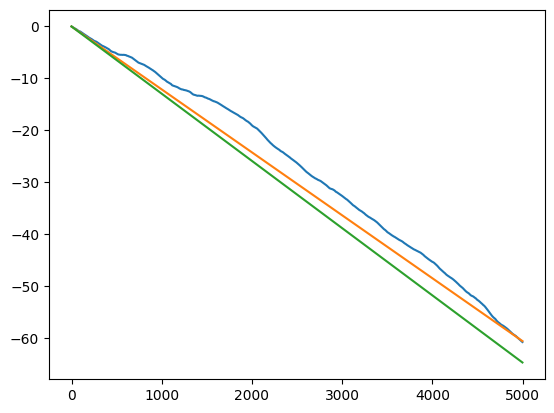

In [35]:
m,c=np.polyfit(np.arange(2500,7500),delays[2500:7500],1)
y=delays[2500:7500]
y-=y[0]
yp=m*np.arange(2500,7500)+c
yp-=yp[0]
print(m,c)
plt.plot(y)
plt.plot(yp)
plt.plot(-1.295e-2*np.arange(0,5000))

Block 0 Expected delta=0.01340021810250818
old alpha 1.340e-02, df 8.507e+00, ddf 1.701e+04, step size 5.003e-04 new alpha 1.290e-02 
old alpha 1.290e-02, df -3.560e+00, ddf 3.105e+04, step size -1.147e-04 new alpha 1.301e-02 
old alpha 1.301e-02, df -1.730e-01, ddf 2.799e+04, step size -6.181e-06 new alpha 1.302e-02 
old alpha 1.302e-02, df -5.265e-04, ddf 2.782e+04, step size -1.893e-08 new alpha 1.302e-02 
rtol hit


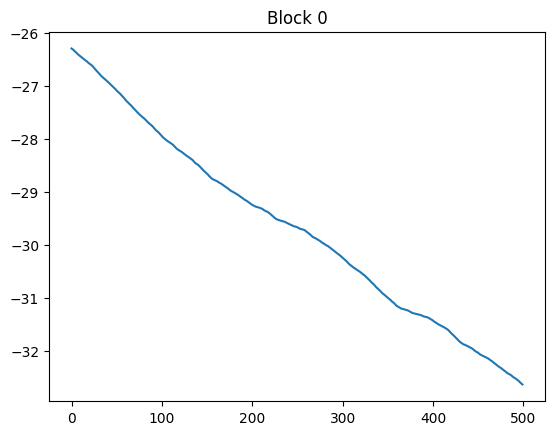

block 0 slope -0.01219405246038656 pred slope -0.01302083073517558
Block 1 Expected delta=-0.3216052344601963
old alpha -3.216e-01, df -5.890e+01, ddf -9.720e+04, step size 6.059e-04 new alpha -3.222e-01 
old alpha -3.222e-01, df -2.523e+00, ddf -8.093e+04, step size 3.117e-05 new alpha -3.222e-01 
rtol hit


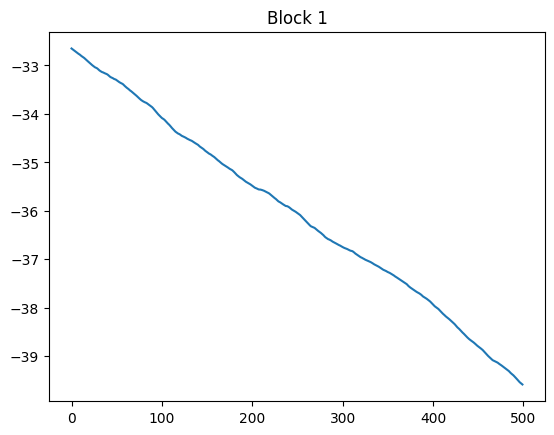

block 1 slope -0.013389472992459434 pred slope 0.3222423163463706
Block 2 Expected delta=0.008933478735005454
old alpha 8.933e-03, df 3.272e+01, ddf -4.321e+04, step size -7.574e-04 new alpha 9.691e-03 
old alpha 9.691e-03, df 1.594e+00, ddf -3.357e+04, step size -4.748e-05 new alpha 9.738e-03 
old alpha 9.738e-03, df 3.682e-02, ddf -3.201e+04, step size -1.150e-06 new alpha 9.739e-03 
old alpha 9.739e-03, df 2.236e-05, ddf -3.197e+04, step size -6.995e-10 new alpha 9.739e-03 
rtol hit


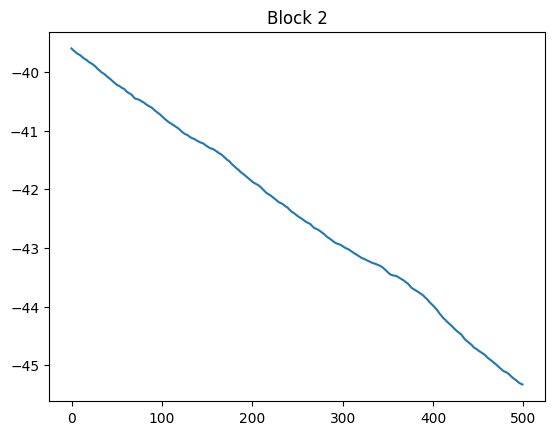

block 2 slope -0.011192277106073116 pred slope -0.009739472073210877
Block 3 Expected delta=0.01340021810250818
old alpha 1.340e-02, df 2.676e+00, ddf -8.764e+04, step size -3.053e-05 new alpha 1.343e-02 
old alpha 1.343e-02, df -9.711e-03, ddf -8.825e+04, step size 1.100e-07 new alpha 1.343e-02 
rtol hit


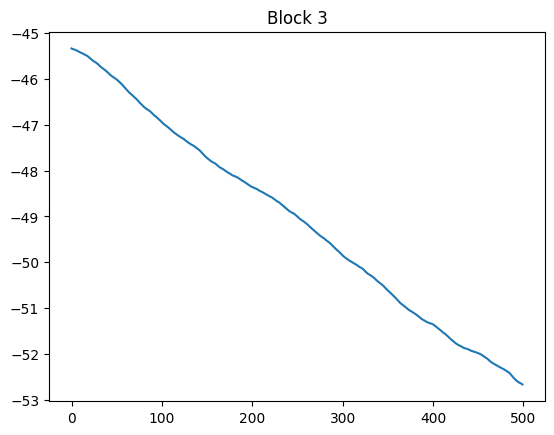

block 3 slope -0.014839405948406563 pred slope -0.013430638989425528
Block 4 Expected delta=0.01340021810250818
old alpha 1.340e-02, df -1.140e+01, ddf -2.060e+04, step size 5.533e-04 new alpha 1.285e-02 
old alpha 1.285e-02, df 2.525e+00, ddf -2.920e+04, step size -8.645e-05 new alpha 1.293e-02 
old alpha 1.293e-02, df 4.559e-02, ddf -2.812e+04, step size -1.621e-06 new alpha 1.293e-02 
old alpha 1.293e-02, df 1.756e-05, ddf -2.810e+04, step size -6.248e-10 new alpha 1.293e-02 
rtol hit


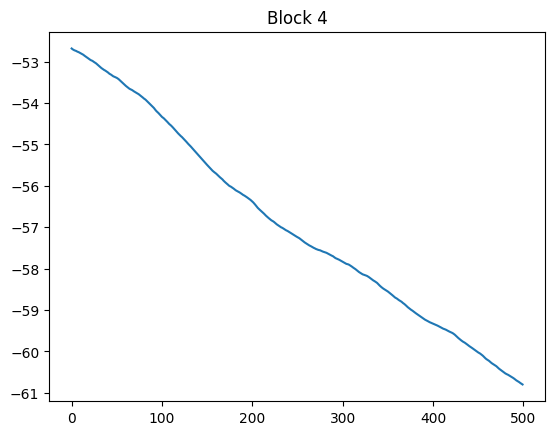

block 4 slope -0.016360754228384216 pred slope -0.01293496047770797
Block 5 Expected delta=0.01340021810250818
old alpha 1.340e-02, df 3.367e+01, ddf -2.431e+04, step size -1.385e-03 new alpha 1.479e-02 
old alpha 1.479e-02, df -3.830e+00, ddf -3.213e+04, step size 1.192e-04 new alpha 1.467e-02 
old alpha 1.467e-02, df -6.420e-02, ddf -3.105e+04, step size 2.068e-06 new alpha 1.466e-02 
old alpha 1.466e-02, df -1.952e-05, ddf -3.103e+04, step size 6.290e-10 new alpha 1.466e-02 
rtol hit


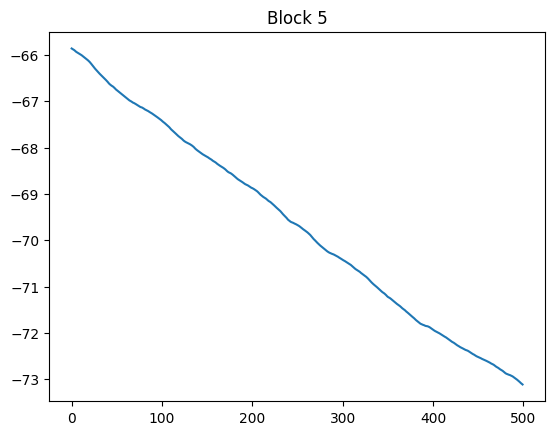

block 5 slope -0.014659289056117216 pred slope -0.014664298206089735
Block 6 Expected delta=0.017866957470010908
old alpha 1.787e-02, df 9.587e+01, ddf 7.850e+03, step size 1.221e-02 new alpha 5.654e-03 
old alpha 5.654e-03, df 2.461e+01, ddf -3.289e+04, step size -7.485e-04 new alpha 6.403e-03 
old alpha 6.403e-03, df -1.702e+01, ddf -7.345e+04, step size 2.317e-04 new alpha 6.171e-03 
old alpha 6.171e-03, df -9.960e-01, ddf -6.424e+04, step size 1.551e-05 new alpha 6.155e-03 
old alpha 6.155e-03, df -5.755e-03, ddf -6.349e+04, step size 9.065e-08 new alpha 6.155e-03 
rtol hit


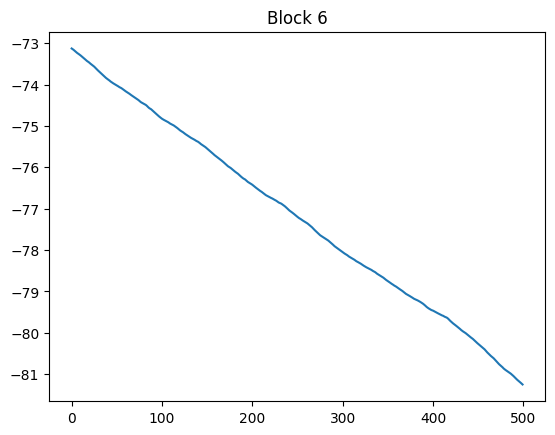

block 6 slope -0.015824057754894396 pred slope -0.006155248733888746
Block 7 Expected delta=0.73701199563795
old alpha 7.370e-01, df -1.187e+01, ddf -1.004e+04, step size 1.183e-03 new alpha 7.358e-01 
old alpha 7.358e-01, df 1.207e+01, ddf -2.816e+04, step size -4.287e-04 new alpha 7.363e-01 
old alpha 7.363e-01, df 9.260e-01, ddf -2.334e+04, step size -3.967e-05 new alpha 7.363e-01 
rtol hit


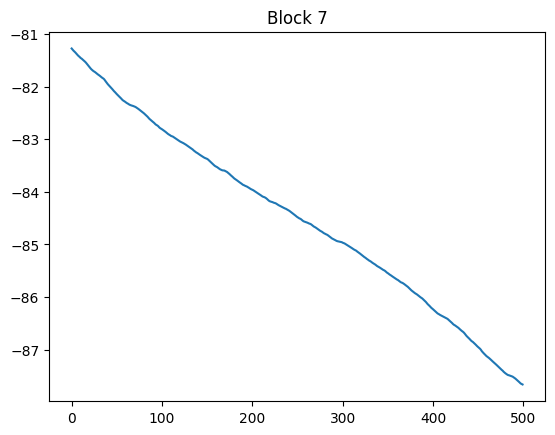

block 7 slope -0.01195176396988296 pred slope -0.7362978803681859
Block 8 Expected delta=0.01340021810250818
old alpha 1.340e-02, df -3.336e+01, ddf 1.152e+05, step size -2.897e-04 new alpha 1.369e-02 
old alpha 1.369e-02, df 1.919e+00, ddf 1.265e+05, step size 1.517e-05 new alpha 1.367e-02 
old alpha 1.367e-02, df 2.302e-03, ddf 1.262e+05, step size 1.824e-08 new alpha 1.367e-02 
rtol hit


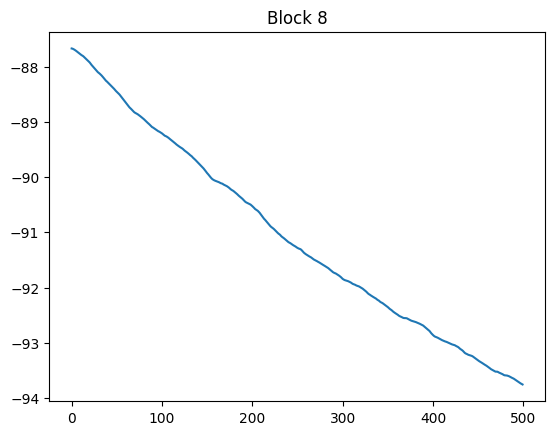

block 8 slope -0.01220019641693303 pred slope -0.013674732991737722
Block 9 Expected delta=-0.9782159214830971
old alpha -9.782e-01, df 1.220e+01, ddf 6.708e+03, step size 1.819e-03 new alpha -9.800e-01 
old alpha -9.800e-01, df -8.260e+00, ddf 1.263e+04, step size -6.540e-04 new alpha -9.794e-01 
old alpha -9.794e-01, df 2.888e-01, ddf 1.288e+04, step size 2.242e-05 new alpha -9.794e-01 
rtol hit


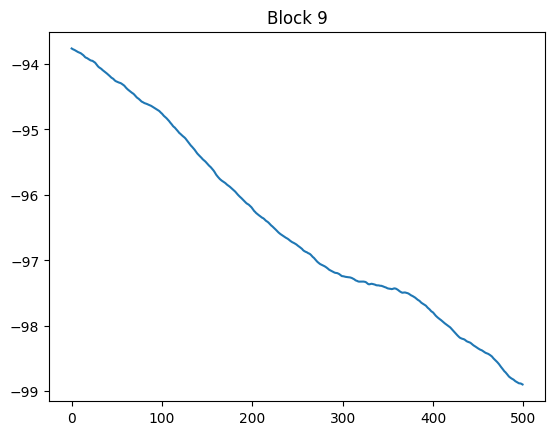

block 9 slope -0.010149431096985335 pred slope 0.9794032258247413


In [103]:
#iterate over several blocks and fit a line
blocksize=500
st=5000
nblocks=10
en=blocksize*nblocks
fit_delta=np.zeros(nblocks,dtype='float64')
for i in range(nblocks):
    #fft and get a coarse guess
    ix=st+i*blocksize
    y1=spec1[ix:ix+blocksize,4]
    y2=spec2[ix:ix+blocksize,4]
    xc_small = y1*np.conj(y2)
    xc_fft = np.fft.fftshift(np.abs(np.fft.fft(xc_small)))

    mm=np.argmax(xc_fft)
    # plt.plot(xc_fft)
    # plt.xlim(mm-100,mm+100)
    M=len(xc_fft)
    # print(M)
    # print("Max at", mm-len(xc_fft)/2)
    expected_delta = (mm-M/2)/M * (4096/1834)
    print(f"Block {i} Expected delta={expected_delta}")
    alpha=solver(xc_small,expected_delta,1834,rtol=1e-4)
    fit_delta[i]=alpha
    plt.title(f"Block {i}")
    plt.plot(delays[ix:ix+blocksize])
    plt.show()

    m,c=np.polyfit(np.arange(ix,ix+blocksize),delays[ix:ix+blocksize],1)
    # m,c=np.polyfit(np.arange(0,en-st),delays[st:en]-delays[st],1)
    print(f"block {i} slope", m, "pred slope", -alpha)

In [85]:
pred_drift=np.zeros(nblocks*blocksize)
t = np.arange(blocksize)
for i in range(nblocks):
    pred_drift[i*blocksize : (i+1)*blocksize] = pred_drift[i*blocksize-1] - 2*np.pi*1834*t*fit_delta[i]/4096

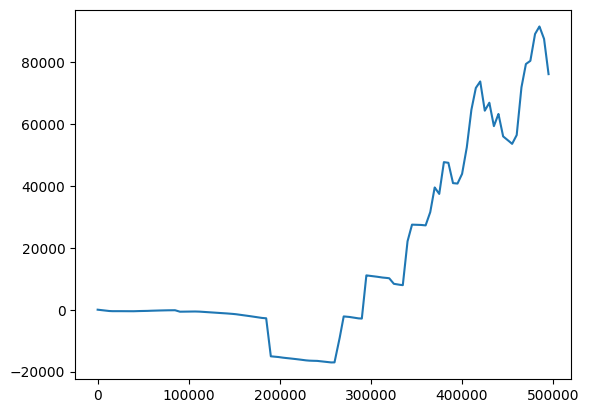

In [87]:
st=0
en=None
plt.plot(pred_drift[st:en])

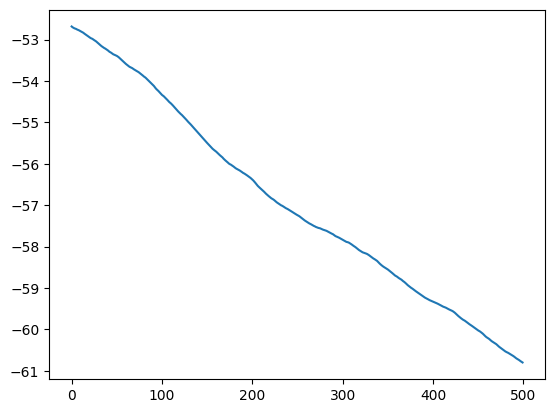

In [95]:
st=7000
en=7500
plt.plot(delays[st:en])